In [4]:
# Ensure notebook is being run from base repository directory
COVID_HOME = "/Users/efua/documents/uni/spring-2021/UROP/covid19-forecast-hub"
import os, sys
try:
    os.chdir(COVID_HOME)
except Exception as err:
    print(f"Warning: unable to change directory; {repr(err)}")
from src.utils.notebook_util import isnotebook
if isnotebook():
    # Autoreload packages that are modified
    %load_ext autoreload
    %autoreload 2
else:
    from argparse import ArgumentParser
    
# Computational libraries 
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy.matlib
from collections import deque

# os libraries 
import shutil
from datetime import datetime, timedelta
from functools import partial
import copy
import pdb
import os

from utils import *
from file_util import *
from attributes import *

from zoo_of_experts import *
from zoo_of_hinters import *
from zoo_of_losses import *

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#
# Specify model parameters
#
model_name = "online_expert" 

if not isnotebook():
    # If notebook run as a script, parse command-line arguments
    parser = ArgumentParser()
    parser.add_argument("pos_vars",nargs="*")  # gt_id and horizon 
    parser.add_argument('--target_dates', '-t', default="std_future")
    args, opt = parser.parse_known_args()
    
    # Assign variables                                                                                                                                     
    gt_id = get_id_name(args.pos_vars[0]) # "contest_precip" or "contest_tmp2m"                                                                            
    horizon = get_th_name(args.pos_vars[1]) # "34w" or "56w"    
    target_date_str = args.target_dates # target date object
else:
    # Otherwise, specify arguments interactively
    gt_id = "cumm_case" #"contest_precip", "contest_tmp2m". choices: "cumm_death", "incd_death", "cumm_case", "incd_case"     
    target_date_str = "std_weekly" #"contest_precip", "contest_tmp2m"
    location = 'US'
    quantile = 0.5
    horizon = "1w"

In [15]:
"""
Read in ground truth and model predictions for task
"""
# Get location FIPS codes
fips_codes = get_fips_codes() 

# Read ground truth 
printf(f'Loading {gt_id} ground truth')
df_gt = get_ground_truth(gt_id, location, load_df=True)

# Get target dates
first_date, last_date = get_data_range(gt_id, location=location)
printf(f"Getting target dates from {first_date} to {last_date}.")
target_dates = get_target_dates(target_date_str, first_date, last_date)
target_date_objs = pd.Series(target_dates)

# Store delta between target date and forecast issuance date
start_delta = timedelta(days=get_start_delta(horizon, gt_id))

# Get model predicitons for the task
printf(f'Loading model predictions for {gt_id}, {horizon}, {location}, q{quantile}')
model_pred_df = get_model_predictions(gt_id, horizon, location=location, quantile=quantile, load_df=True)

# Get model list
persistant_models, all_models = get_persistant_models(model_pred_df)
expert_models = list(all_models)
expert_models.sort()
model_string = (',').join(expert_models)
printf(f"Predictions for models loaded:\n {expert_models}")

Loading cumm_case ground truth
Getting target dates from 2020-01-22 00:00:00 to 2021-03-30 00:00:00.
Loading model predictions for cumm_case, 1w, US, q0.5


IndexError: index -1 is out of bounds for axis 0 with size 0

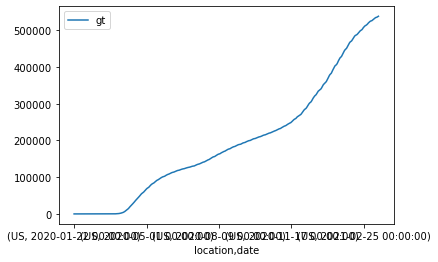

In [9]:
df_gt.plot()

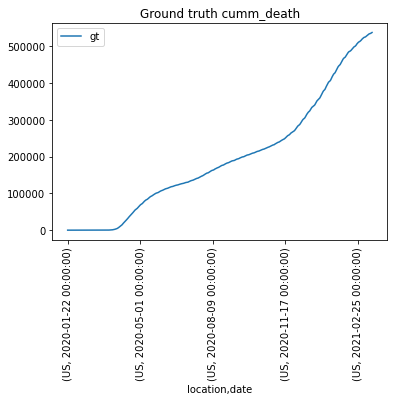

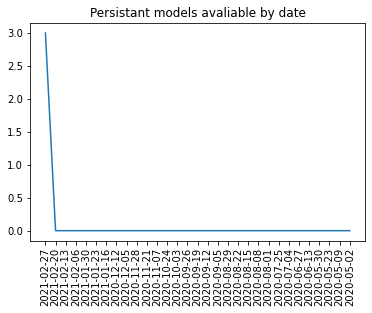

In [17]:
"""
Visualize ground truth 
"""
df_gt.plot()
plt.xticks(rotation=90)
plt.title(f'Ground truth {gt_id}')
plt.show()

"""
Visualize avalible models
"""
plt.plot(list(persistant_models.keys()), [len(x) for x in persistant_models.values()])
plt.xticks(rotation=90)
plt.title('Persistant models avaliable by date')
plt.show()

In [47]:
#loading expert models
print("testing: cumulative deaths, 1 wk horizon")
print("")

print("expert models DF:")
model_pred_df = get_model_predictions(gt_id, horizon, location=location, quantile=quantile, load_df=True)
model_pred_df.head(100)



testing: cumulative deaths, 1 wk horizon

expert models DF:


,,,value
model,location,target_end_date,
CU-nochange,US,2020-05-02,69433.000000
CU-scenario_mid,US,2020-05-02,69407.000000
GT-DeepCOVID,US,2020-05-09,77808.163100
UT-Mobility,US,2020-05-23,96128.000000
Imperial-ensemble1,US,2020-05-30,104662.000000
Imperial-ensemble2,US,2020-05-30,104671.000000
CU-select,US,2020-06-13,115784.000000
YYG-ParamSearch,US,2020-06-27,123770.842279
SWC-TerminusCM,US,2020-07-04,128581.000000


expert model median plot:


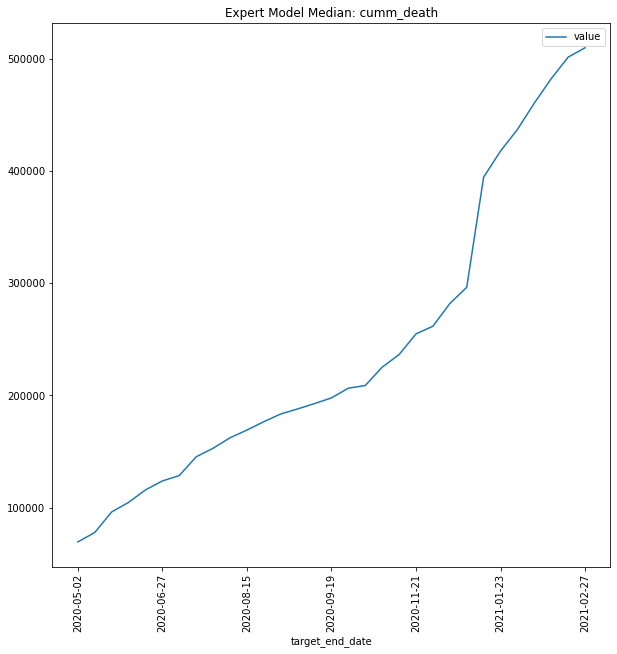


expert model mean plot:


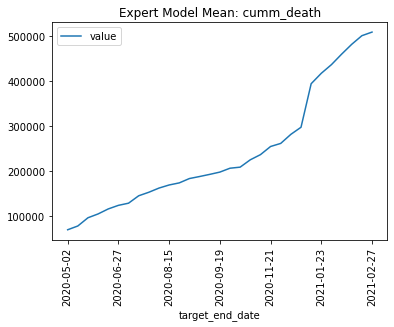


groundtruth plot:


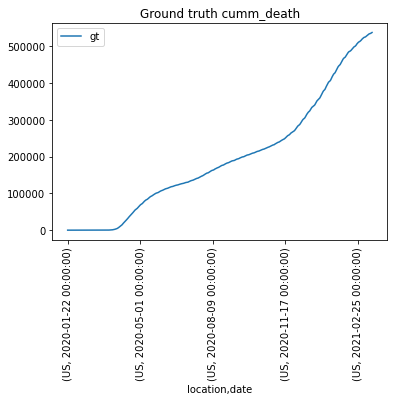

In [13]:
#creating mean and median plots for expert models
print("expert model median plot:")
med_df = model_pred_df.groupby(['target_end_date']).median()
med_df.plot(figsize=(10,10));
plt.xticks(rotation=90)
plt.title(f'Expert Model Median: {gt_id}')
plt.show()



print("")
print("expert model mean plot:")
mea_df = model_pred_df.groupby(['target_end_date']).mean()
mea_df.plot()
plt.xticks(rotation=90)
plt.title(f'Expert Model Mean: {gt_id}')
plt.show()

print("")
print("groundtruth plot:")
df_gt.plot()
plt.xticks(rotation=90)
plt.title(f'Ground truth {gt_id}')
plt.show()
print("")


models per date plot:


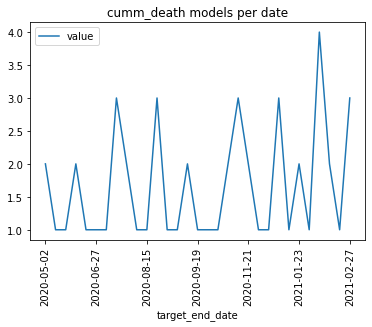

In [56]:
#visualize model count for each date
mod_per_date = model_pred_df.groupby(by='target_end_date').count()
print("")
print("models per date plot:")
mod_per_date.plot()
plt.xticks(rotation=90)
plt.title(f'{gt_id} models per date')
plt.show()
print("")

In [63]:
#pandas series of median values
pd.Series(data=med_df, index=['target_end_date'])

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [12]:
type(med_df)

pandas.core.frame.DataFrame